In [12]:
import random
from typing import Union

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import transformers

In [13]:
# ######################## PART 1: PROVIDED CODE ########################
def load_datasets(data_directory: str) -> Union[dict, dict]:
    """
    Reads the training and validation splits from disk and load
    them into memory.

    Parameters
    ----------
    data_directory: str
        The directory where the data is stored.

    Returns
    -------
    train: dict
        The train dictionary with keys 'premise', 'hypothesis', 'label'.
    validation: dict
        The validation dictionary with keys 'premise', 'hypothesis', 'label'.
    """
    import json
    import os

    with open(os.path.join(data_directory, "train.json"), "r") as f:
        train = json.load(f)

    with open(os.path.join(data_directory, "validation.json"), "r") as f:
        valid = json.load(f)

    return train, valid


class NLIDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict: dict):
        self.data_dict = data_dict
        dd = data_dict

        if len(dd["premise"]) != len(dd["hypothesis"]) or len(dd["premise"]) != len(
                dd["label"]
        ):
            raise AttributeError("Incorrect length in data_dict")

    def __len__(self):
        return len(self.data_dict["premise"])

    def __getitem__(self, idx):
        dd = self.data_dict
        return dd["premise"][idx], dd["hypothesis"][idx], dd["label"][idx]


def train_distilbert(model, loader, device):
    model.train()
    criterion = model.get_criterion()
    total_loss = 0.0

    for premise, hypothesis, target in tqdm(loader):
        optimizer.zero_grad()

        inputs = model.tokenize(premise, hypothesis).to(device)
        target = target.to(device, dtype=torch.float32)

        pred = model(inputs)

        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def eval_distilbert(model, loader, device):
    model.eval()

    targets = []
    preds = []

    for premise, hypothesis, target in loader:
        preds.append(model(model.tokenize(premise, hypothesis).to(device)))

        targets.append(target)

    return torch.cat(preds), torch.cat(targets)

In [14]:
class CustomDistilBert(nn.Module):
    def __init__(self):
        """
        CustomDistilBert.__init__
        Note:
        ● Load the DistilBERT model's pretrained "base uncased" weights from the Huggingface
        repository. We want the bare encoder outputting hidden-states without any specific head
        on top.
        ● Load the corresponding pre-trained tokenizer using the same method.
        ● self.pred_layer takes the output of the model and predicts a single score (binary, 1 or 0),
        then pass the output to the sigmoid layer
        ● self.sigmoid should return torch's sigmoid activation.
        ● self.criterion should be the binary cross-entropy loss. You may use torch.nn here.
        """
        super().__init__()

        # TODO: your work below
        self.distilbert = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.pred_layer = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

    # vvvvv DO NOT CHANGE BELOW THIS LINE vvvvv
    def get_distilbert(self):
        return self.distilbert

    def get_tokenizer(self):
        return self.tokenizer

    def get_pred_layer(self):
        return self.pred_layer

    def get_sigmoid(self):
        return self.sigmoid

    def get_criterion(self):
        return self.criterion

    # ^^^^^ DO NOT CHANGE ABOVE THIS LINE ^^^^^

    def assign_optimizer(self, **kwargs):
        """
        CustomDistilBert.assign_optimizer
        This assigns the Adam optimizer to this model's parameters (self) and returns the optimizer.
        :param kwargs:
        :return:
        """
        # TODO: your work below
        return torch.optim.Adam(self.parameters(), **kwargs)

    def slice_cls_hidden_state(
            self, x
    ) -> torch.Tensor:
        """
        Edit the method CustomDistilBert.slice_cls_hidden_state. This is a helper method that will be
        used inside forward, and will convert the output of your transformer model to something that can
        be input in the prediction layer.
        CustomDistilBert.slice_cls_hidden_state
        Using the output of the model, return the last hidden state of the CLS token.
        ParameterTypeDescription
        xBaseModelOutputThe output of the distilbert model. You need to retrieve
        the hidden state of the last output layer, then slice it to
        obtain the hidden representation. The last hidden state
        has shape: [batch_size, sequence_length,
        hidden_size]
        ReturnsDescription
        Tensor[batch_size,
        hidden_size]The last layer's hidden state representing the [CLS] token.
        Usually, CLS is the first token in the sequence.
        :param x:
        :return:
        """
        # TODO: your work below
        return x.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

    def tokenize(
            self,
            premise: "list[str]",
            hypothesis: "list[str]",
            max_length: int = 128,
            truncation: bool = True,
            padding: bool = True,
    ):
        """
        Use the get_tokenizer function implemented in 2.1 to write the method
        CustomDistilBert.tokenize. That method is specifically to help you understand how the
        tokenizer works, and should be fairly straightforward.
        This function will be applied to the premise and hypothesis (list of str) to obtain the inputs for
        your model. You will need to use the Huggingface tokenizer returned by get_tokenizer().
        ParameterTypeDescription
        premiselist of strThe first text to be input in your model.
        hypothesislist of strThe second text to be input in your model.
        For the remaining params, see documentations.
        ReturnsDescription
        BatchEncodingA dictionary-like object that can be given to the model (you
        can find out how by reading the docs)
        :param premise:
        :param hypothesis:
        :param max_length:
        :param truncation:
        :param padding:
        :return:
        """
        # TODO: your work below
        return self.tokenizer(
            premise,
            hypothesis,
            max_length=max_length,
            truncation=truncation,
            padding=padding,
            return_tensors="pt",
        )

    def forward(self, inputs):
        """
        Given the output of your tokenizer (a BatchEncoding object), you will have to pass through your
        custom DistilBert model and output a score between 0 and 1 for each element in your batch;
        this score represents whether there’s an entailment or not.
        CustomDistilBert.forward
        Note: In the original BERT paper, the output representation of CLS is used for classification.
        You will need to slice the output of your DistilBERT to obtain the representation before giving it
        to the last layer with sigmoid activation.
        :param inputs:
        :return:
        """
        # TODO: your work below
        x = self.distilbert(**inputs, return_dict=True)
        x = self.slice_cls_hidden_state(x)
        x = self.pred_layer(x)
        x = self.sigmoid(x)
        x = x.squeeze(1)
        return x

Running test code for part 1
--------------------------------------------------------------------------------


  2%|▎         | 1/40 [00:00<00:04,  8.37it/s]

Epoch: 0
Training loss: 0.6116886422038078
Training accuracy: 0.8308
Validation accuracy: 0.8056



  5%|▌         | 2/40 [00:00<00:02, 14.47it/s]

Epoch: 1
Training loss: 0.325053272023797
Training accuracy: 0.9396
Validation accuracy: 0.8488



  5%|▌         | 2/40 [00:00<00:02, 14.88it/s]

Epoch: 2
Training loss: 0.18662585616111754
Training accuracy: 0.9836
Validation accuracy: 0.8824



  5%|▌         | 2/40 [00:00<00:02, 13.09it/s]

Epoch: 3
Training loss: 0.08945085634477437
Training accuracy: 0.9884
Validation accuracy: 0.8636



  5%|▌         | 2/40 [00:00<00:02, 14.81it/s]

Epoch: 4
Training loss: 0.05372771078837104
Training accuracy: 0.9944
Validation accuracy: 0.8848



  5%|▌         | 2/40 [00:00<00:02, 15.89it/s]

Epoch: 5
Training loss: 0.03154317061998881
Training accuracy: 0.9984
Validation accuracy: 0.884



  5%|▌         | 2/40 [00:00<00:02, 13.96it/s]

Epoch: 6
Training loss: 0.027722314739366993
Training accuracy: 0.9992
Validation accuracy: 0.8856



  5%|▌         | 2/40 [00:00<00:02, 14.91it/s]

Epoch: 7
Training loss: 0.014022979329456575
Training accuracy: 0.9988
Validation accuracy: 0.8896



  5%|▌         | 2/40 [00:00<00:02, 15.08it/s]

Epoch: 8
Training loss: 0.0261068334322772
Training accuracy: 0.9992
Validation accuracy: 0.8752



100%|██████████| 40/40 [00:02<00:00, 16.58it/s]


Epoch: 9
Training loss: 0.036133991336100735
Training accuracy: 0.998
Validation accuracy: 0.8784



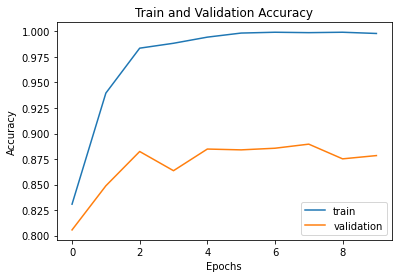

In [15]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score  # Make sure sklearn is installed

random.seed(2022)
torch.manual_seed(2022)

# Parameters (you can change them)
sample_size = 2500  # Change this if you want to take a subset of data for testing
batch_size = 64
n_epochs = 10
num_words = 50000

# If you use GPUs, use the code below:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ###################### PART 1: TEST CODE ######################
# Prefilled code showing you how to use the helper functions
train_raw, valid_raw = load_datasets("data/nli")
if sample_size is not None:
    for key in ["premise", "hypothesis", "label"]:
        train_raw[key] = train_raw[key][:sample_size]
        valid_raw[key] = valid_raw[key][:sample_size]

full_text = (
        train_raw["premise"]
        + train_raw["hypothesis"]
        + valid_raw["premise"]
        + valid_raw["hypothesis"]
)

print("=" * 80)
print("Running test code for part 1")
print("-" * 80)

train_loader = torch.utils.data.DataLoader(
    NLIDataset(train_raw), batch_size=batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    NLIDataset(valid_raw), batch_size=batch_size, shuffle=False
)

model = CustomDistilBert().to(device)
optimizer = model.assign_optimizer(lr=1e-4)
"""
Upload a plot of the accuracy over time for both the training and validation sets (use different colors and label this inside a legend), where the X axis is the number of epochs, the Y axis is the accuracy (NOT loss).

You can use matplotlib, seaborn, plotly, or anything else to generate it. Please upload a JPEG or a PNG, or else you might have some points deduced.
"""
train_accs = []
valid_accs = []
for epoch in range(n_epochs):
    loss = train_distilbert(model, train_loader, device=device)

    preds, targets = eval_distilbert(model, train_loader, device=device)
    preds = preds.round()
    acc = accuracy_score(targets.cpu(), preds.cpu())
    train_accs.append(acc)
    val_preds, val_targets = eval_distilbert(model, valid_loader, device=device)
    val_preds = val_preds.round()
    val_acc = accuracy_score(val_targets.cpu(), val_preds.cpu())
    valid_accs.append(val_acc)

    # score = f1_score(targets.cpu(), preds.cpu())

    print("Epoch:", epoch)
    print("Training loss:", loss)
    print("Training accuracy:", acc)
    print("Validation accuracy:", val_acc)
    # print("Validation F1 score:", score)
    print()

# plot train and validation accuracy
import matplotlib.pyplot as plt
plt.plot(train_accs, label='train')
plt.plot(valid_accs, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.savefig('train_valid_acc.png')
plt.show()

In [16]:
"""
Select 3 pairs from the validation set, and run your model on those 3 examples. Then, paste the pairs, the true label, and the predicted label in the text box below, using the following format:

Premise: <write your premise here>
Hypothesis: <write your hypothesis here>
True Label: <the label that came from the validation set>
Predicted Label: <what was output by your model>
"""
# select 3 pairs from the validation set
valid_loader = torch.utils.data.DataLoader(
    NLIDataset(valid_raw), batch_size=1, shuffle=False,
)
model.eval()
count = 0
for premise, hypothesis, target in valid_loader:
    preds = model(model.tokenize(premise, hypothesis).to(device))
    preds = preds.round()
    print('Premise:', premise)
    print('Hypothesis:', hypothesis)
    print('True Label:', target)
    print('Predicted Label:', preds)
    print()
    count += 1
    if count == 3:
        break

Premise: ('Two women are embracing while holding to go packages.',)
Hypothesis: ('Two woman are holding packages.',)
True Label: tensor([0])
Predicted Label: tensor([0.], device='cuda:0', grad_fn=<RoundBackward>)

Premise: ('Two women are embracing while holding to go packages.',)
Hypothesis: ('The men are fighting outside a deli.',)
True Label: tensor([1])
Predicted Label: tensor([1.], device='cuda:0', grad_fn=<RoundBackward>)

Premise: ('Two young children in blue jerseys, one with the number 9 and one with the number 2 are standing on wooden steps in a bathroom and washing their hands in a sink.',)
Hypothesis: ('Two kids in numbered jerseys wash their hands.',)
True Label: tensor([0])
Predicted Label: tensor([1.], device='cuda:0', grad_fn=<RoundBackward>)

